#### 1.生成模拟数据集

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

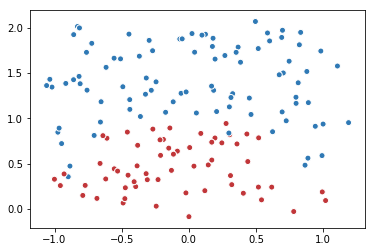

In [13]:
data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音
for i in range(150):
    # 从均匀分布中抽取样本
    x1 = np.random.uniform(-1, 1)
    x2 = np.random.uniform(0, 2)
    if x1**2 + x2**2 <= 1:
        # 从正太分布中抽取样本
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)

# 按水平顺序堆叠列表，并调整shape
data = np.hstack(data).reshape(-1, 2)
label = np.hstack(label).reshape(-1, 1)

# 绘制散点图
plt.scatter(x=data[:, 0], 
            y=data[:, 1], 
            c=label, 
            cmap="RdBu", 
            vmin=-0.2, 
            vmax=1.2, 
            edgecolors="white")
plt.show()

#### 2.定义一个权重，并自动加入正则项到损失函数

In [14]:
def get_weight(shape, lambda1):
    # 生成一个变量
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    
    # add_to_collection函数将这个新生成的变量的L2正则化加入集合
    # 这个函数的第一个参数"losses"是集合的名字，第二个参数是要加入这个集合的任务
    tf.add_to_collection("loss", tf.contrib.layers.l2_regularizer(lambda1)(var))
    
    # 返回生成的变量
    return var

In [15]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)

layer_dimension = [2, 10, 5, 3, 1] # 每层节点数
n_layers = len(layer_dimension) # 神经网络的层数
cur_layer = x  # 神经网络当前层的输出值
in_dimension = layer_dimension[0] # 输入层的个数

# 循环生成网络结构
for i in range(1, n_layers):
    # 输出层的节点数
    out_dimension = layer_dimension[i] 
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]
    
y = cur_layer

# 损失函数的定义
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2))/sample_size
tf.add_to_collection("losses", mse_loss)
loss = tf.add_n(tf.get_collection("losses"))

In [ ]:
# 定义训练的目标函数mse_loss, 训练次数以及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 40000

# 定义会话
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as sess:
    # 变量初始化
    tf.global_variables_initializer().run()
    
    # 训练
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_:label})
        if i % 2000 == 0:
            mse_loss_value = sess.run(mse_loss, feed_dict={x: data, y_:label})
            print("Afetr %d steps, mse_loss: %f" % (i, mse_loss_value))
    
    # 画出训练后的分割线
    xx, yy = np.mgrid[-1.2:1.2:0.01, -0.2:2.2:0.01]
    grid = np.c_[xx.ravl(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)
    
# 画出散点图
plt.scatter(data[:,0], data[:,1], c=label, 
            cmap="RdBu", vmin=-0.2, vmax=1.2, edgecolor="white")
# 画出分界线
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=0.1)

# 显示图片
plt.show()

In [6]:
# np.mgrid的用法
# 产生多维格点数据

print(np.mgrid[0:5, 0:5])
print(np.mgrid[0:1:0.2])

[[[0 0 0 0 0]
  [1 1 1 1 1]
  [2 2 2 2 2]
  [3 3 3 3 3]
  [4 4 4 4 4]]

 [[0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]
  [0 1 2 3 4]]]
[ 0.   0.2  0.4  0.6  0.8]


In [ ]:
# numpy.ravel() vs numpy.flatten()
# 两者的功能都是将多维数组转化为一维，两者的区别在于是返回视图还是返回拷贝；
# ravel()返回的时视图，flatten()返回的是拷贝

# 两者的功能
>>> x = np.array([[1, 2], [3, 4]])
>>> x
array([[1, 2],
       [3, 4]])
>>> x.flatten()
array([1, 2, 3, 4])
>>> x.ravel()
array([1, 2, 3, 4])
                    两者默认均是行序优先
>>> x.flatten('F')
array([1, 3, 2, 4])
>>> x.ravel('F')
array([1, 3, 2, 4])

>>> x.reshape(-1)
array([1, 2, 3, 4])
>>> x.T.reshape(-1)
array([1, 3, 2, 4])

# 两者的区别
>>> x = np.array([[1, 2], [3, 4]])
>>> x.flatten()[1] = 100
>>> x
array([[1, 2],
       [3, 4]])            # flatten：返回的是拷贝
>>> x.ravel()[1] = 100
>>> x
array([[  1, 100],
       [  3,   4]])

In [ ]:
# numpy.c_[]的用法
# 将切片对象转化为第二个对象的连接
>>> np.c_[np.array([1,2,3]), np.array([4,5,6])]
array([[1, 4],
       [2, 5],
       [3, 6]])
>>> np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
array([[1, 2, 3, 0, 0, 4, 5, 6]])

In [ ]:
# plt.contor()绘制轮廓